In [11]:
from pathlib import Path
import os
import pandas as pd
from sklearn.calibration import CalibratedClassifierCV
import statkit
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import plotly.express as px
import pylab
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.calibration import calibration_curve
import seaborn as sns
from typing import List, Tuple
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


sns.set_theme()

## Predicting Numerical Values with Machine Learning

- MLR
- Lasso regression
- KNN
- Random Forest
- XGBoost

In [25]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ---------------------------
# 1. Load Data
# ---------------------------
# Load your field mapping that contains "Field Name", "Source", and "Indicator Category"
fieldMapping_df = pd.read_csv('Field Mapping List.csv')
print("Field Mapping Preview:")
print(fieldMapping_df.head())

# Load your cleaned dataset
df = pd.read_csv('Group1DatasetCleaned.csv')

# ---------------------------
# 2. Drop Unwanted Columns
# ---------------------------
# Define initial drop list for essential columns you do not want in predictors
dropList = ['Life expectancy at birth, total (years)', 'CountryShortName', 'Year']

# Identify columns that contain "male" or "female" (ignore case)
cols_to_drop = [col for col in df.columns if 'male' in col.lower() or 'female' in col.lower()]

# Combine the initial dropList with the columns identified above
all_drop_columns = list(set(dropList + cols_to_drop))

# Create the target variable (Y) and a predictor DataFrame (df_predictors) containing all non-dropped columns
Y = df['Life expectancy at birth, total (years)']
df_predictors = df.drop(columns=all_drop_columns)

# ---------------------------
# 3. Create Indicator Category Sets
# ---------------------------
# Get lists of column names from the field mapping for each indicator category.
# (These lists come from the "Field Mapping List.csv" where each row has a "Field Name" and an "Indicator Category".)

env_cols = set(fieldMapping_df.loc[fieldMapping_df['Indicator Category'] == 'Environmental', 'Field Name'])
socio_cols = set(fieldMapping_df.loc[fieldMapping_df['Indicator Category'] == 'Socioeconomic', 'Field Name'])
health_cols = set(fieldMapping_df.loc[fieldMapping_df['Indicator Category'] == 'Health', 'Field Name'])

# Ensure that we only retain those columns which exist in the predictors DataFrame.
env_cols = list(env_cols.intersection(set(df_predictors.columns)))
socio_cols = list(socio_cols.intersection(set(df_predictors.columns)))
health_cols = list(health_cols.intersection(set(df_predictors.columns)))

# Create separate predictor sets for each category
X_env = df_predictors[env_cols]
X_socio = df_predictors[socio_cols]
X_health = df_predictors[health_cols]

print("Environmental columns:")
print(env_cols)
print("\nSocioeconomic columns:")
print(socio_cols)
print("\nHealth columns:")
print(health_cols)

# ---------------------------
# 4. Define VIF Functions
# ---------------------------
def calculate_vif(df_subset):
    """Calculate VIF for each numerical feature in a DataFrame."""
    vif_data = pd.DataFrame()
    vif_data["feature"] = df_subset.columns
    vif_data["VIF"] = [
        round(variance_inflation_factor(df_subset.values, i), 4) for i in range(df_subset.shape[1])
    ]
    return vif_data

def iterative_vif_drop(X, threshold=4):
    """
    Iteratively drop the column with the highest VIF above `threshold` until
    all remaining columns have VIF <= threshold.
    """
    while True:
        vif_df = calculate_vif(X)
        max_vif = vif_df["VIF"].max()
        if max_vif > threshold:
            drop_col = vif_df.loc[vif_df["VIF"].idxmax(), "feature"]
            print(f"Dropping '{drop_col}' with VIF={max_vif:.2f}")
            X = X.drop(columns=[drop_col])
        else:
            break
    return X

# ---------------------------
# 5. Evaluate Each Predictor Set Using VIF
# ---------------------------
print("\n--- Environmental Predictors VIF ---")
vif_env = calculate_vif(X_env)
print(vif_env)
X_env_reduced = iterative_vif_drop(X_env, threshold=4)
print("Final VIF for Environmental predictors:")
print(calculate_vif(X_env_reduced))

print("\n--- Socioeconomic Predictors VIF ---")
vif_socio = calculate_vif(X_socio)
print(vif_socio)
X_socio_reduced = iterative_vif_drop(X_socio, threshold=4)
print("Final VIF for Socioeconomic predictors:")
print(calculate_vif(X_socio_reduced))

print("\n--- Health Predictors VIF ---")
vif_health = calculate_vif(X_health)
print(vif_health)
X_health_reduced = iterative_vif_drop(X_health, threshold=4)
print("Final VIF for Health predictors:")
print(calculate_vif(X_health_reduced))


Field Mapping Preview:
                                          Field Name                   Source  \
0    GOAL 13: Climate Action (5 year moving average)             SPIIndicator   
1  Fluorinated greenhouse gases (F-gases) emissio...  WDIEnvironmentIndicator   
2  Total greenhouse gas emissions including LULUC...  WDIEnvironmentIndicator   
3  Carbon dioxide (CO2) net fluxes from LULUCF - ...  WDIEnvironmentIndicator   
4  Carbon dioxide (CO2) net fluxes from LULUCF - ...  WDIEnvironmentIndicator   

  Indicator Category  
0      Environmental  
1      Environmental  
2      Environmental  
3      Environmental  
4      Environmental  
Environmental columns:
['Access to clean fuels and technologies for cooking (% of population)', 'Mineral rents (% of GDP)', 'Permanent cropland (% of land area)', 'Carbon dioxide (CO2) emissions from Industrial Processes (Mt CO2e)', 'Total greenhouse gas emissions per capita excluding LULUCF (t CO2e/capita)', 'Arable land (hectares per person)', 'Tot

In [26]:
vif_dropList = [
    "Rural population (% of total population)","Region_South Asia","GDP, PPP (current international $)","Prevalence of anemia among women of reproductive age (% of women ages 15-49)","Total greenhouse gas emissions excluding LULUCF (Mt CO2e)","GNI (current US$)","Carbon dioxide (CO2) emissions (total) excluding LULUCF (Mt CO2e)","Domestic credit to private sector by banks (% of GDP)","Nitrous oxide (N2O) emissions (total) excluding LULUCF (Mt CO2e)","GDP (current US$)","Number of infant deaths","Wage and salaried workers, total (% of total employment) (modeled ILO estimate)","Labor force, total","Methane (CH4) emissions (total) excluding LULUCF (Mt CO2e)","Employment to population ratio, 15+, total (%) (modeled ILO estimate)","Nitrous oxide (N2O) emissions from Industrial Combustion (Energy) (Mt CO2e)","Population ages 0-14, total","Current health expenditure per capita (current US$)","GDP (constant 2015 US$)","Total fisheries production (metric tons)","GNI, Atlas method (current US$)","Surface area (sq. km)","Access to clean fuels and technologies for cooking (% of population)","GDP, PPP (constant 2021 international $)","GDP per capita, PPP (current international $)","Carbon dioxide (CO2) emissions from Transport (Energy) (Mt CO2e)","Number of deaths ages 10-14 years","Number of under-five deaths","Current health expenditure per capita, PPP (current international $)","GDP per capita (current US$)","Employment to population ratio, ages 15-24, total (%) (modeled ILO estimate)","Domestic private health expenditure per capita, PPP (current international $)","Mortality rate, under-5 (per 1,000 live births)","GDP per capita, PPP (constant 2021 international $)","Urban population","Final consumption expenditure (constant 2015 US$)","Vulnerable employment, total (% of total employment) (modeled ILO estimate)","Carbon dioxide (CO2) emissions from Industrial Combustion (Energy) (Mt CO2e)","GNI per capita, Atlas method (current US$)","Nitrous oxide (N2O) emissions from Agriculture (Mt CO2e)","Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)","Carbon dioxide (CO2) emissions from Power Industry (Energy) (Mt CO2e)","Number of deaths ages 15-19 years","Domestic general government health expenditure per capita (current US$)","Nitrous oxide (N2O) emissions from Waste (Mt CO2e)","Income Group_High income","Lifetime risk of maternal death (%)","Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)","Adjusted net national income (current US$)","Population ages 0-14 (% of total population)","Rural population","People using at least basic sanitation services (% of population)","Total greenhouse gas emissions including LULUCF (Mt CO2e)","GDP growth (annual %)","GNI, PPP (current international $)","Nitrous oxide (N2O) emissions from Transport (Energy) (Mt CO2e)","Mortality rate, infant (per 1,000 live births)","GDP per capita (constant 2015 US$)","Land under cereal production (hectares)","Out-of-pocket expenditure per capita (current US$)","Computer, communications and other services (% of commercial service imports)","Forest area (sq. km)","Number of deaths ages 20-24 years","Carbon dioxide (CO2) emissions from Industrial Processes (Mt CO2e)","Domestic general government health expenditure (% of GDP)","Nitrous oxide (N2O) emissions from Building (Energy) (Mt CO2e)","Prevalence of anemia among pregnant women (%)","Number of deaths ages 5-9 years","Computer, communications and other services (% of commercial service exports)","Methane (CH4) emissions from Agriculture (Mt CO2e)","GNI per capita, PPP (current international $)","Access to electricity (% of population)","Oil rents (% of GDP)","Birth rate, crude (per 1,000 people)","Cereal production (metric tons)","Carbon dioxide (CO2) emissions from Fugitive Emissions (Energy) (Mt CO2e)","Probability of dying among children ages 5-9 years (per 1,000)","Domestic private health expenditure (% of current health expenditure)","Exports of goods, services and primary income (BoP, current US$)","Region_Europe & Central Asia","Adjusted net national income per capita (current US$)","Probability of dying among adolescents ages 15-19 years (per 1,000)","Monetary Sector credit to private sector (% GDP)","Carbon dioxide (CO2) emissions from Building (Energy) (Mt CO2e)","Prevalence of anemia among children (% of children ages 6-59 months)","Methane (CH4) emissions from Waste (Mt CO2e)","Unemployment, total (% of total labor force) (modeled ILO estimate)","Primary education, pupils","School enrollment, primary (% gross)","Crop production index (2014-2016 = 100)","Livestock production index (2014-2016 = 100)","Carbon intensity of GDP (kg CO2e per 2021 PPP $)","Access to clean fuels and technologies for cooking, urban (% of urban population)","People using at least basic sanitation services, rural (% of rural population)","GOAL 17: Partnerships to achieve the Goal (5 year moving average)","Land area (sq. km)","Share of youth not in education, employment or training, total (% of youth population) (modeled ILO estimate)","Fluorinated greenhouse gases (F-gases) emissions from Industrial Processes (Mt CO2e)","People using at least basic drinking water services (% of population)","Travel services (% of commercial service exports)","GDP per person employed (constant 2021 PPP $)","Number of neonatal deaths","General government final consumption expenditure (constant 2015 US$)","People using at least basic drinking water services, urban (% of urban population)","Population ages 15-64 (% of total population)","Immunization, DPT (% of children ages 12-23 months)","Pillar 3 - Data Products - Score","Labor force participation rate, total (% of total population ages 15+) (modeled ILO estimate)","Access to electricity, urban (% of urban population)","People using at least basic sanitation services, urban (% of urban population)","Import unit value index (2015 = 100)","Immunization, measles (% of children ages 12-23 months)","GOAL 15: Life on Land (5 year moving average)","Women Business and the Law Index Score (scale 1-100)","Domestic general government health expenditure (% of current health expenditure)","Tuberculosis case detection rate (%, all forms)","Food production index (2014-2016 = 100)","Tuberculosis treatment success rate (% of new cases)","Communications, computer, etc. (% of service imports, BoP)","Urban population (% of total population)","Death rate, crude (per 1,000 people)","Export unit value index (2015 = 100)","Self-employed, total (% of total employment) (modeled ILO estimate)","Access to electricity, rural (% of rural population)","Compulsory education, duration (years)","Mortality rate, neonatal (per 1,000 live births)","Labor force participation rate for ages 15-24, total (%) (modeled ILO estimate)","Current health expenditure (% of GDP)","Renewable energy consumption (% of total final energy consumption)","Prevalence of anemia among non-pregnant women (% of women ages 15-49)","GOAL 1: No Poverty (5 year moving average)","GOAL 10: Reduced Inequality (5 year moving average)","Probability of dying among youth ages 20-24 years (per 1,000)","Household Survey on income, etc (Availability score over 10 years)","Inflation, GDP deflator: linked series (annual %)","Adolescent fertility rate (births per 1,000 women ages 15-19)","Out-of-pocket expenditure per capita, PPP (current international $)","Carbon intensity of GDP (kg CO2e per constant 2021 US$ of GDP)","Access to clean fuels and technologies for cooking, rural (% of rural population)","Agricultural land (% of land area)","Nitrous oxide (N2O) emissions from Industrial Processes (Mt CO2e)","GOAL 16: Peace and Justice Strong Institutions (5 year moving average)","Carbon dioxide (CO2) net fluxes from LULUCF - Deforestation (Mt CO2e)","Domestic general government health expenditure per capita, PPP (current international $)","Transport services (% of commercial service imports)","Total natural resources rents (% of GDP)","Broad money (% of GDP)","Adjusted savings: education expenditure (% of GNI)","Pillar 1 - Data Use - Score","Energy intensity level of primary energy (MJ/$2017 PPP GDP)","Methane (CH4) emissions from Industrial Combustion (Energy) (Mt CO2e)","Agriculture, forestry, and fishing, value added (% of GDP)","Probability of dying among adolescents ages 10-14 years (per 1,000)","Methane (CH4) emissions from Power Industry (Energy) (Mt CO2e)","PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)","Prevalence of stunting, height for age (modeled estimate, % of children under 5)","GOAL 11: Sustainable Cities and Communities (5 year moving average)","Income Group_Lower middle income","International tourism, receipts for travel items (current US$)","Preprimary education, duration (years)","Total greenhouse gas emissions excluding LULUCF (% change from 1990)","Methane (CH4) emissions from Building (Energy) (Mt CO2e)","Exports of goods and services (% of GDP)","Domestic credit to private sector (% of GDP)","Methane (CH4) emissions from Transport (Energy) (Mt CO2e)","Maternal mortality ratio (modeled estimate, per 100,000 live births)","Total greenhouse gas emissions per capita excluding LULUCF (t CO2e/capita)","Methane (CH4) emissions from Fugitive Emissions (Energy) (Mt CO2e)","Health/Demographic survey (Availability score over 10 years)","Prevalence of overweight (modeled estimate, % of children under 5)","Out-of-pocket expenditure (% of current health expenditure)","Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)","Urban population growth (annual %)","Forest area (% of land area)","Renewable internal freshwater resources, total (billion cubic meters)","Automated teller machines (ATMs) (per 100,000 adults)","Adjusted savings: carbon dioxide damage (% of GNI)","Proportion of seats held by women in national parliaments (%)","Domestic private health expenditure per capita (current US$)","GOAL 12: Responsible Consumption and Production (5 year moving average)","Nitrous oxide (N2O) emissions from Power Industry (Energy) (Mt CO2e)","Labor Force Survey (Availability score over 10 years)","Fuel imports (% of merchandise imports)","Fuel exports (% of merchandise exports)","Prevalence of undernourishment (% of population)","Arable land (% of land area)","Insurance and financial services (% of commercial service imports)","Region_Sub-Saharan Africa","Communications, computer, etc. (% of service exports, BoP)","Travel services (% of commercial service imports)","Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate)" 
]

# X_reduced = X.drop(vif_dropList, axis=1)

In [27]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

def scale_split_data(X, Y, test_size=0.2, random_state=135):
    """
    Convert data to float, perform train-test split,
    scale the data using StandardScaler, and add a constant for the intercept.
    
    Parameters:
        X (DataFrame): Predictor features.
        Y (Series): Target variable.
        test_size (float): Proportion of data to use for testing.
        random_state (int): Random seed for reproducibility.
        
    Returns:
        X_train_scaled (DataFrame): Scaled training predictors with an added constant.
        X_test_scaled (DataFrame): Scaled testing predictors with an added constant.
        y_train (Series): Training target variable.
        y_test (Series): Testing target variable.
    """
    # Convert to float if necessary
    X = X.astype(float)
    Y = Y.astype(float)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=test_size, random_state=random_state
    )
    
    # Initialize and fit the StandardScaler on training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert scaled arrays back to DataFrames to preserve column names
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    
    # Add a constant to account for the intercept in the regression model
    X_train_scaled = sm.add_constant(X_train_scaled)
    X_test_scaled = sm.add_constant(X_test_scaled)
    
    return X_train_scaled, X_test_scaled, y_train, y_test


def fit_ols_and_evaluate(X_train_scaled, y_train, X_test_scaled, y_test):
    """
    Fit an OLS regression model using statsmodels, print the model summary,
    perform predictions on the test set, and calculate performance metrics.
    
    Parameters:
        X_train_scaled (DataFrame): Scaled training predictors (with constant added).
        y_train (Series): Training target variable.
        X_test_scaled (DataFrame): Scaled testing predictors (with constant added).
        y_test (Series): Testing target variable.
        
    Returns:
        model: The fitted OLS regression model.
        results (dict): A dictionary with predictions, MSE, and R-squared.
    """
    # Fit the OLS model on the training data
    model = sm.OLS(y_train, X_train_scaled).fit()
    print(model.summary())
    
    # Predict on the test set
    y_pred = model.predict(X_test_scaled)
    
    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("Test Mean Squared Error:", mse)
    print("Test R-squared:", r2)
    
    results = {"y_pred": y_pred, "mse": mse, "r2": r2}
    return model, results


# --- Running Models for Each Indicator Category ---

# 1. Environmental Predictors
print("=== Environmental Predictors Model ===")
X_train_env, X_test_env, y_train_env, y_test_env = scale_split_data(X_env_reduced, Y)
model_env, results_env = fit_ols_and_evaluate(X_train_env, y_train_env, X_test_env, y_test_env)


# 2. Socioeconomic Predictors
print("\n=== Socioeconomic Predictors Model ===")
X_train_socio, X_test_socio, y_train_socio, y_test_socio = scale_split_data(X_socio_reduced, Y)
model_socio, results_socio = fit_ols_and_evaluate(X_train_socio, y_train_socio, X_test_socio, y_test_socio)


# 3. Health Predictors
print("\n=== Health Predictors Model ===")
X_train_health, X_test_health, y_train_health, y_test_health = scale_split_data(X_health_reduced, Y)
model_health, results_health = fit_ols_and_evaluate(X_train_health, y_train_health, X_test_health, y_test_health)


=== Environmental Predictors Model ===
                                       OLS Regression Results                                      
Dep. Variable:     Life expectancy at birth, total (years)   R-squared:                       0.669
Model:                                                 OLS   Adj. R-squared:                  0.665
Method:                                      Least Squares   F-statistic:                     184.6
Date:                                     Wed, 09 Apr 2025   Prob (F-statistic):               0.00
Time:                                             20:35:19   Log-Likelihood:                -6898.5
No. Observations:                                     2308   AIC:                         1.385e+04
Df Residuals:                                         2282   BIC:                         1.400e+04
Df Model:                                               25                                         
Covariance Type:                                 nonrobust   

Category: Environmental
========== Environmental - Linear Regression ==========
Test MSE: 23.9106115536372
Test R²: 0.6639932265013571
Test MAE: 3.6765615841118184
Test RMSE: 4.8898478047519225
Test Median AE: 2.7829462100924687
Explained Variance: 0.6642811400366805
Adjusted R²: 0.6481380974433448
Cross-validated RMSE: 4.855383751717147
========== Environmental - Ridge Regression ==========
Test MSE: 23.908927123590367
Test R²: 0.6640168971592133
Test MAE: 3.676492261588194
Test RMSE: 4.889675564246606
Test Median AE: 2.7843684081290263
Explained Variance: 0.6643037119309381
Adjusted R²: 0.6481628850469439
Cross-validated RMSE: 4.855327845694036
========== Environmental - Lasso Regression ==========
Test MSE: 23.855162186033628
Test R²: 0.6647724354755492
Test MAE: 3.6517181568803205
Test RMSE: 4.8841746678465165
Test Median AE: 2.710419051046763
Explained Variance: 0.6648970293534667
Adjusted R²: 0.6489540748990779
Cross-validated RMSE: 4.879888556945147
========== Environmental - El

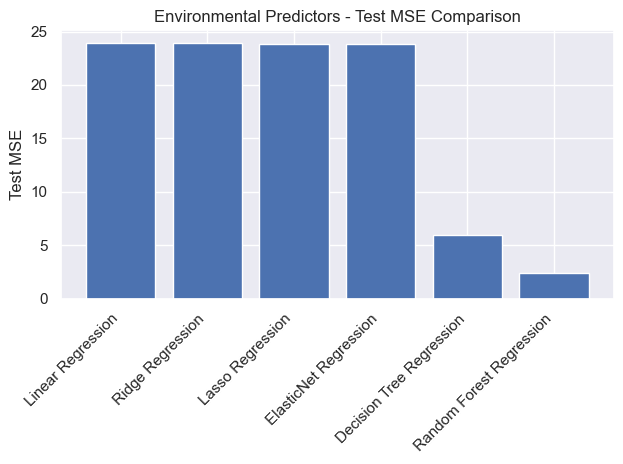


Summary Table for Test MSE:
                   Model  Test MSE
       Linear Regression 23.910612
        Ridge Regression 23.908927
        Lasso Regression 23.855162
   ElasticNet Regression 23.828920
Decision Tree Regression  5.924814
Random Forest Regression  2.364525




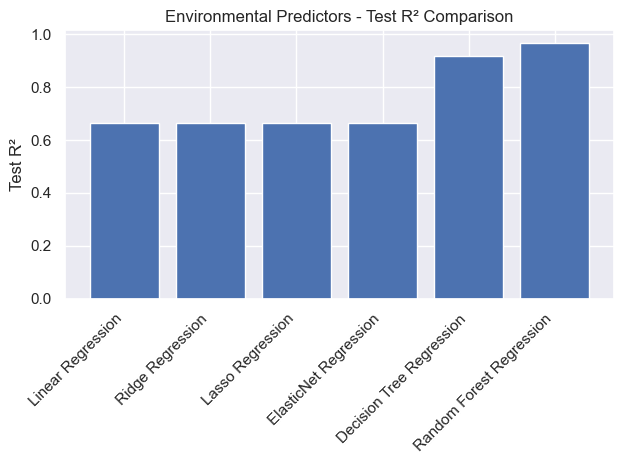


Summary Table for Test R²:
                   Model  Test R²
       Linear Regression 0.663993
        Ridge Regression 0.664017
        Lasso Regression 0.664772
   ElasticNet Regression 0.665141
Decision Tree Regression 0.916741
Random Forest Regression 0.966772




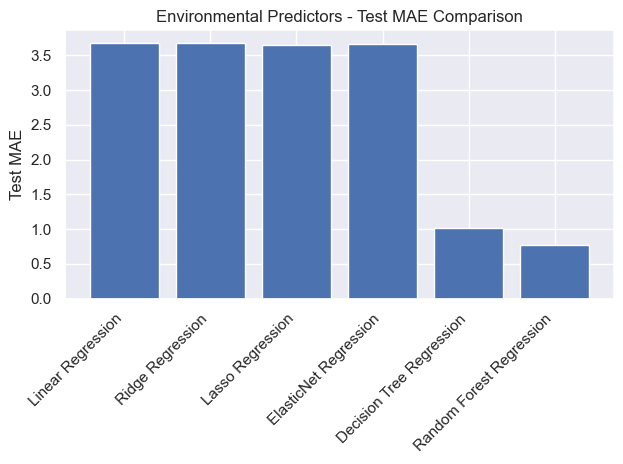


Summary Table for Test MAE:
                   Model  Test MAE
       Linear Regression  3.676562
        Ridge Regression  3.676492
        Lasso Regression  3.651718
   ElasticNet Regression  3.664005
Decision Tree Regression  1.016895
Random Forest Regression  0.768693




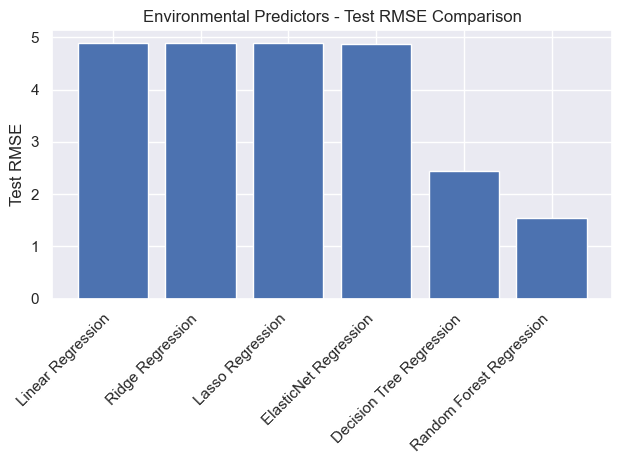


Summary Table for Test RMSE:
                   Model  Test RMSE
       Linear Regression   4.889848
        Ridge Regression   4.889676
        Lasso Regression   4.884175
   ElasticNet Regression   4.881487
Decision Tree Regression   2.434094
Random Forest Regression   1.537701




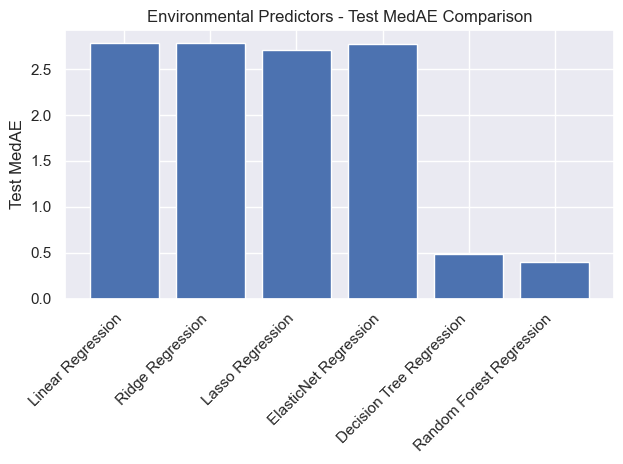


Summary Table for Test MedAE:
                   Model  Test MedAE
       Linear Regression    2.782946
        Ridge Regression    2.784368
        Lasso Regression    2.710419
   ElasticNet Regression    2.773256
Decision Tree Regression    0.488000
Random Forest Regression    0.399190




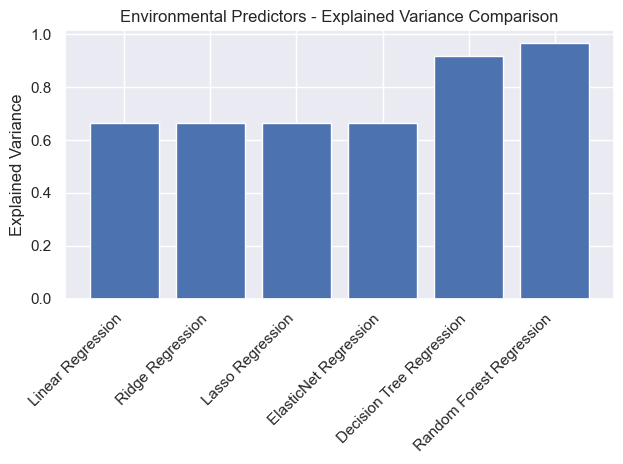


Summary Table for Explained Variance:
                   Model  Explained Variance
       Linear Regression            0.664281
        Ridge Regression            0.664304
        Lasso Regression            0.664897
   ElasticNet Regression            0.665266
Decision Tree Regression            0.916937
Random Forest Regression            0.967054




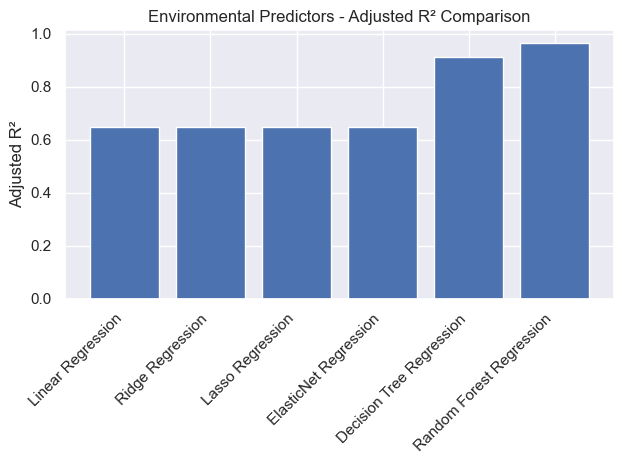


Summary Table for Adjusted R²:
                   Model  Adjusted R²
       Linear Regression     0.648138
        Ridge Regression     0.648163
        Lasso Regression     0.648954
   ElasticNet Regression     0.649340
Decision Tree Regression     0.912812
Random Forest Regression     0.965204




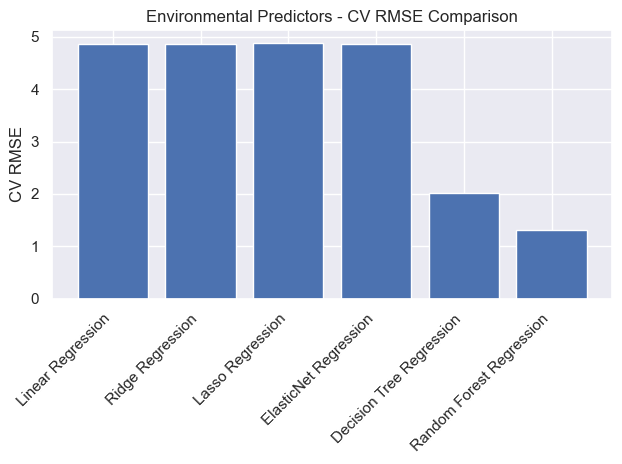


Summary Table for CV RMSE:
                   Model  CV RMSE
       Linear Regression 4.855384
        Ridge Regression 4.855328
        Lasso Regression 4.879889
   ElasticNet Regression 4.871517
Decision Tree Regression 2.025483
Random Forest Regression 1.312108




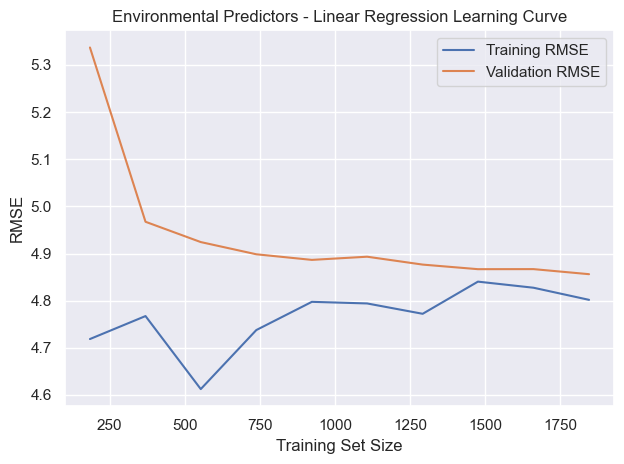

Category: Socioeconomic
========== Socioeconomic - Linear Regression ==========
Test MSE: 17.235880482353878
Test R²: 0.7577906957213315
Test MAE: 3.162052971536262
Test RMSE: 4.151611793310386
Test Median AE: 2.6116643542148097
Explained Variance: 0.7579569816407922
Adjusted R²: 0.7440388854051434
Cross-validated RMSE: 4.127247133002832
========== Socioeconomic - Ridge Regression ==========
Test MSE: 17.235320043042968
Test R²: 0.7577985713628298
Test MAE: 3.1619920123217016
Test RMSE: 4.1515442961677484
Test Median AE: 2.613883245867349
Explained Variance: 0.7579642485897947
Adjusted R²: 0.7440472081984484
Cross-validated RMSE: 4.127180000977967
========== Socioeconomic - Lasso Regression ==========
Test MSE: 17.633993753935474
Test R²: 0.7521961606099627
Test MAE: 3.177450590619808
Test RMSE: 4.199284909831134
Test Median AE: 2.508373851836211
Explained Variance: 0.752296983032408
Adjusted R²: 0.7381267118533856
Cross-validated RMSE: 4.154712614923389
========== Socioeconomic - Elas

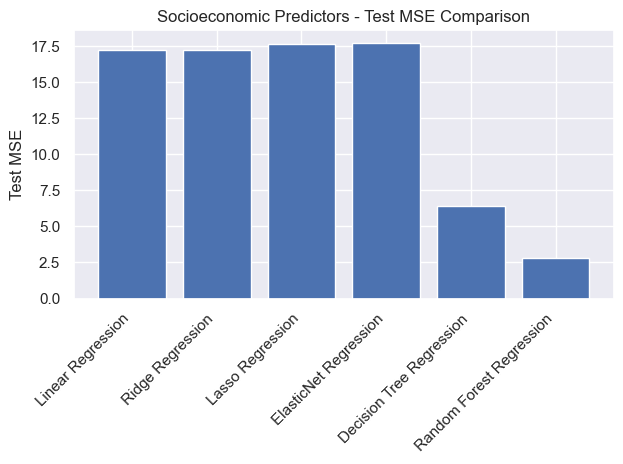


Summary Table for Test MSE:
                   Model  Test MSE
       Linear Regression 17.235880
        Ridge Regression 17.235320
        Lasso Regression 17.633994
   ElasticNet Regression 17.717761
Decision Tree Regression  6.425002
Random Forest Regression  2.783198




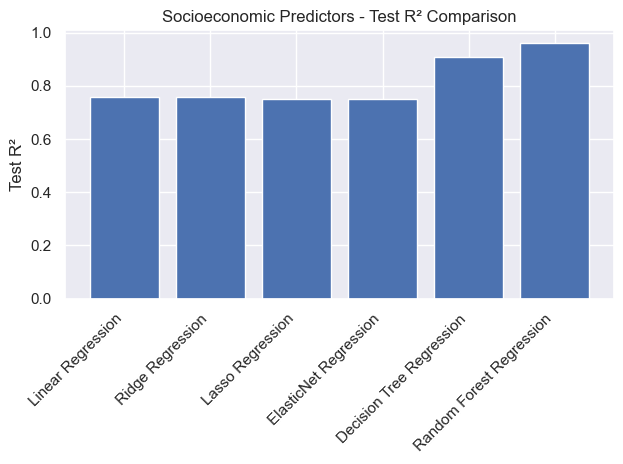


Summary Table for Test R²:
                   Model  Test R²
       Linear Regression 0.757791
        Ridge Regression 0.757799
        Lasso Regression 0.752196
   ElasticNet Regression 0.751019
Decision Tree Regression 0.909712
Random Forest Regression 0.960889




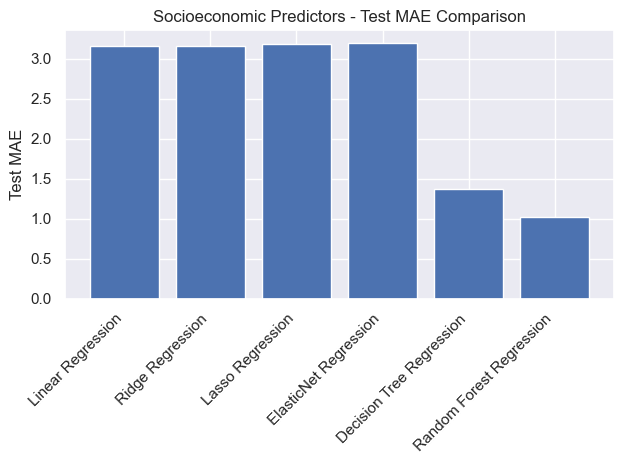


Summary Table for Test MAE:
                   Model  Test MAE
       Linear Regression  3.162053
        Ridge Regression  3.161992
        Lasso Regression  3.177451
   ElasticNet Regression  3.192417
Decision Tree Regression  1.369793
Random Forest Regression  1.021712




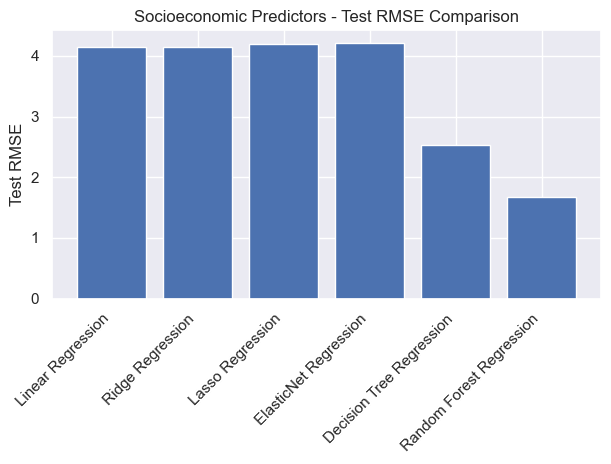


Summary Table for Test RMSE:
                   Model  Test RMSE
       Linear Regression   4.151612
        Ridge Regression   4.151544
        Lasso Regression   4.199285
   ElasticNet Regression   4.209247
Decision Tree Regression   2.534759
Random Forest Regression   1.668292




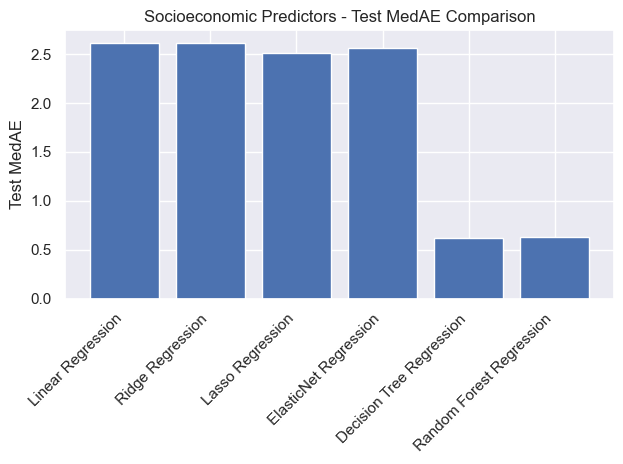


Summary Table for Test MedAE:
                   Model  Test MedAE
       Linear Regression    2.611664
        Ridge Regression    2.613883
        Lasso Regression    2.508374
   ElasticNet Regression    2.565155
Decision Tree Regression    0.616000
Random Forest Regression    0.625405




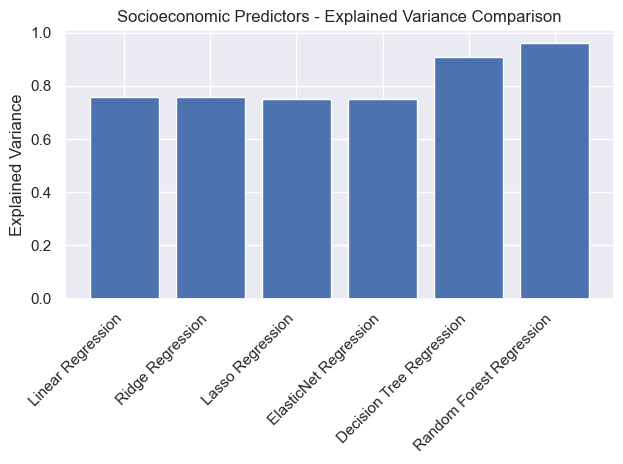


Summary Table for Explained Variance:
                   Model  Explained Variance
       Linear Regression            0.757957
        Ridge Regression            0.757964
        Lasso Regression            0.752297
   ElasticNet Regression            0.751096
Decision Tree Regression            0.910641
Random Forest Regression            0.961042




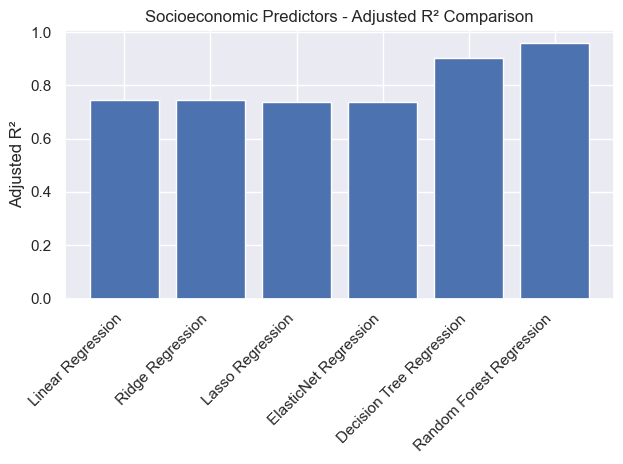


Summary Table for Adjusted R²:
                   Model  Adjusted R²
       Linear Regression     0.744039
        Ridge Regression     0.744047
        Lasso Regression     0.738127
   ElasticNet Regression     0.736883
Decision Tree Regression     0.904586
Random Forest Regression     0.958668




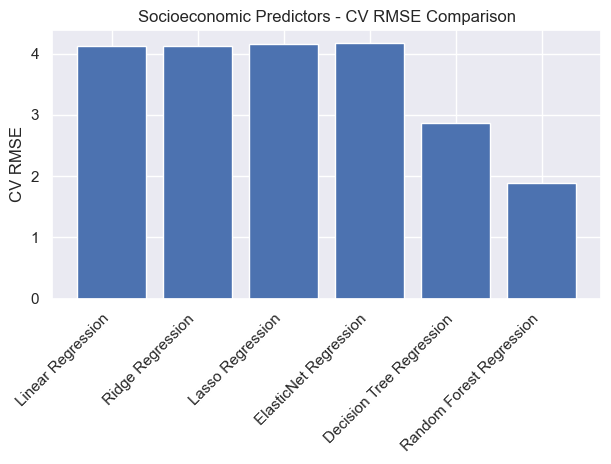


Summary Table for CV RMSE:
                   Model  CV RMSE
       Linear Regression 4.127247
        Ridge Regression 4.127180
        Lasso Regression 4.154713
   ElasticNet Regression 4.170009
Decision Tree Regression 2.872551
Random Forest Regression 1.885494




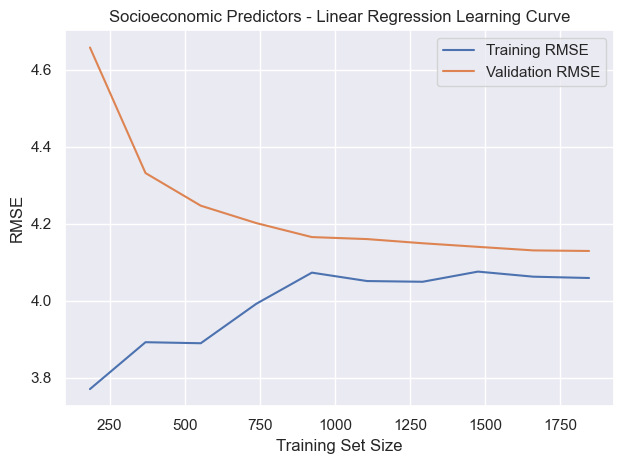

Category: Health
========== Health - Linear Regression ==========
Test MSE: 8.931779663912964
Test R²: 0.8744850812477163
Test MAE: 2.330892747967288
Test RMSE: 2.9886083155731473
Test Median AE: 1.9169471787768764
Explained Variance: 0.8749664228219094
Adjusted R²: 0.8720457453709052
Cross-validated RMSE: 2.909371550028574
========== Health - Ridge Regression ==========
Test MSE: 8.930734483447267
Test R²: 0.8744997687731781
Test MAE: 2.330788204801543
Test RMSE: 2.988433449727008
Test Median AE: 1.9146501739392612
Explained Variance: 0.8749815297847008
Adjusted R²: 0.8720607183429749
Cross-validated RMSE: 2.9093337273929594
========== Health - Lasso Regression ==========
Test MSE: 8.919776580845777
Test R²: 0.8746537560306424
Test MAE: 2.331325307022706
Test RMSE: 2.986599501246489
Test Median AE: 1.9404843911917702
Explained Variance: 0.8751933351219129
Adjusted R²: 0.8722176982856549
Cross-validated RMSE: 2.9298887016672666
========== Health - ElasticNet Regression ==========
Test 

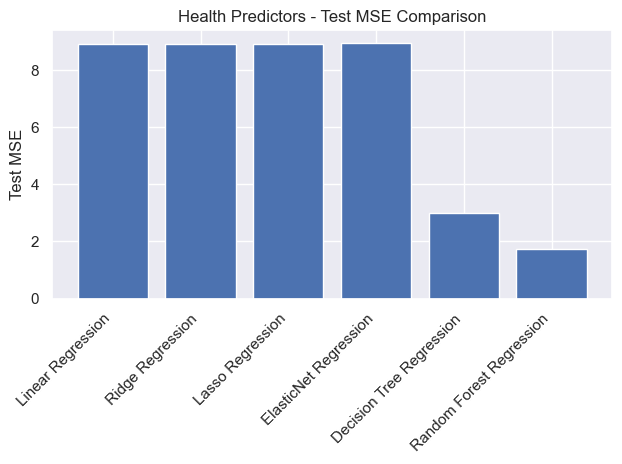


Summary Table for Test MSE:
                   Model  Test MSE
       Linear Regression  8.931780
        Ridge Regression  8.930734
        Lasso Regression  8.919777
   ElasticNet Regression  8.948141
Decision Tree Regression  3.011406
Random Forest Regression  1.722898




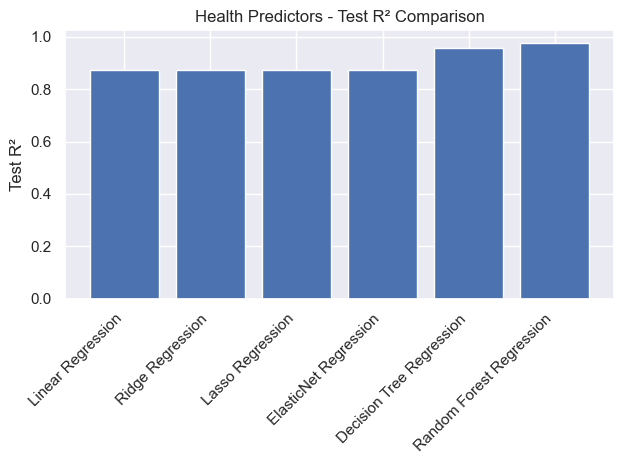


Summary Table for Test R²:
                   Model  Test R²
       Linear Regression 0.874485
        Ridge Regression 0.874500
        Lasso Regression 0.874654
   ElasticNet Regression 0.874255
Decision Tree Regression 0.957682
Random Forest Regression 0.975789




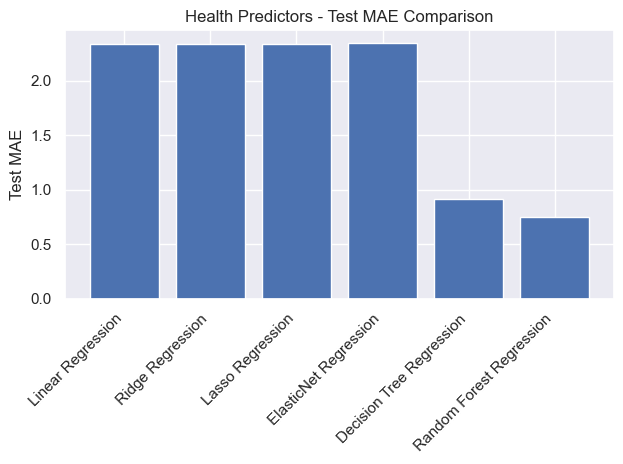


Summary Table for Test MAE:
                   Model  Test MAE
       Linear Regression  2.330893
        Ridge Regression  2.330788
        Lasso Regression  2.331325
   ElasticNet Regression  2.342419
Decision Tree Regression  0.915488
Random Forest Regression  0.750957




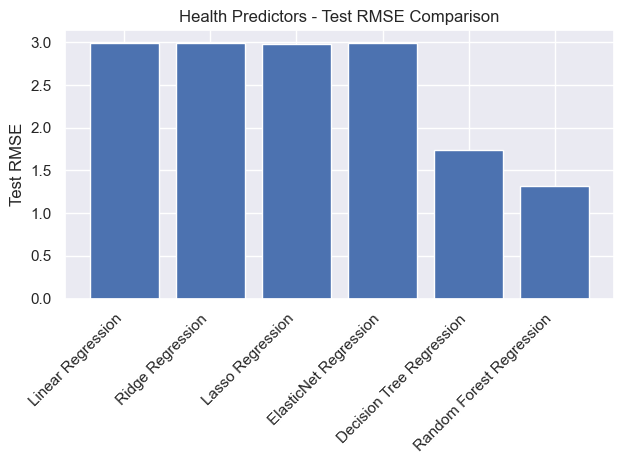


Summary Table for Test RMSE:
                   Model  Test RMSE
       Linear Regression   2.988608
        Ridge Regression   2.988433
        Lasso Regression   2.986600
   ElasticNet Regression   2.991344
Decision Tree Regression   1.735340
Random Forest Regression   1.312592




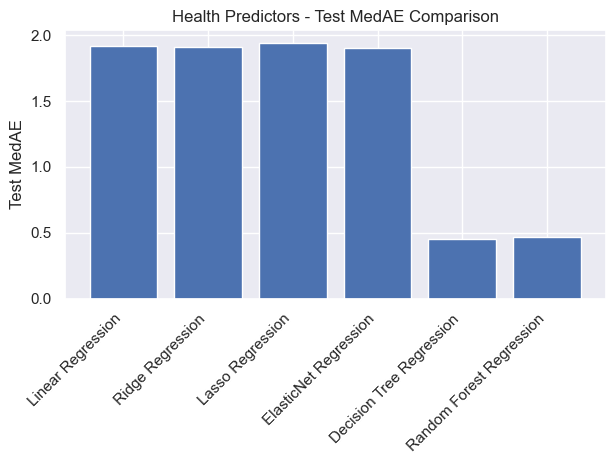


Summary Table for Test MedAE:
                   Model  Test MedAE
       Linear Regression    1.916947
        Ridge Regression    1.914650
        Lasso Regression    1.940484
   ElasticNet Regression    1.907145
Decision Tree Regression    0.451220
Random Forest Regression    0.470241




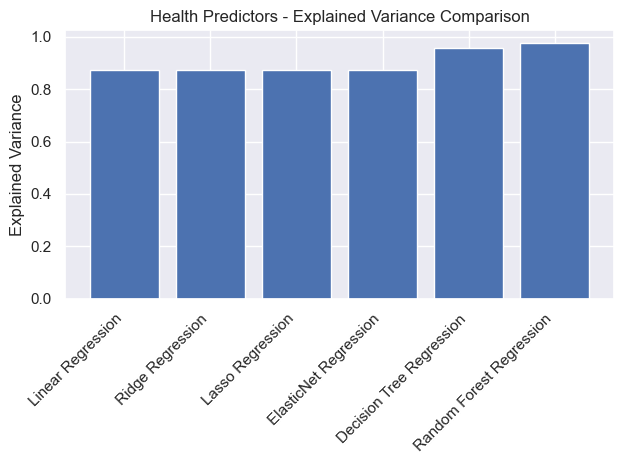


Summary Table for Explained Variance:
                   Model  Explained Variance
       Linear Regression            0.874966
        Ridge Regression            0.874982
        Lasso Regression            0.875193
   ElasticNet Regression            0.874786
Decision Tree Regression            0.957690
Random Forest Regression            0.975861




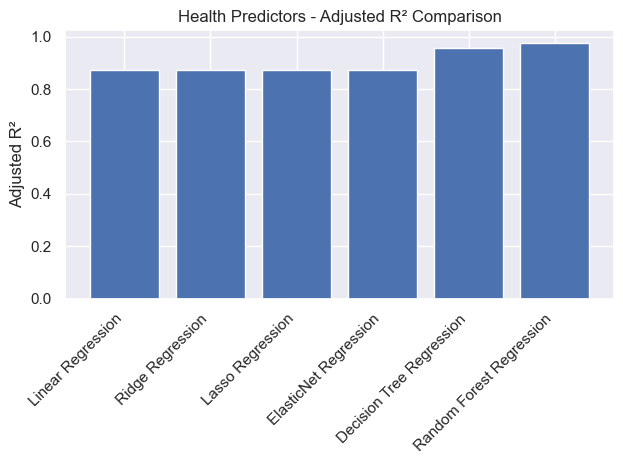


Summary Table for Adjusted R²:
                   Model  Adjusted R²
       Linear Regression     0.872046
        Ridge Regression     0.872061
        Lasso Regression     0.872218
   ElasticNet Regression     0.871811
Decision Tree Regression     0.956859
Random Forest Regression     0.975318




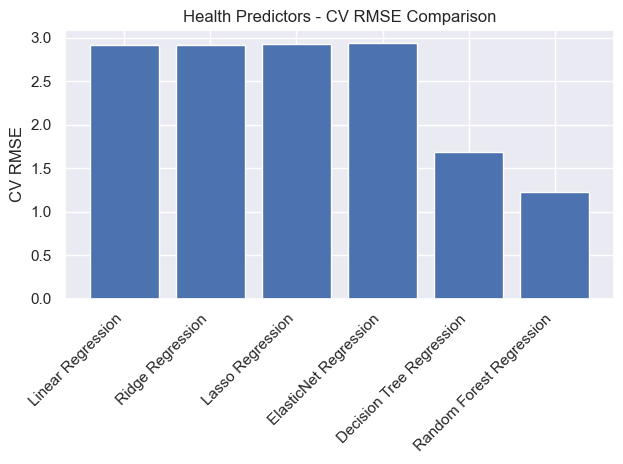


Summary Table for CV RMSE:
                   Model  CV RMSE
       Linear Regression 2.909372
        Ridge Regression 2.909334
        Lasso Regression 2.929889
   ElasticNet Regression 2.935709
Decision Tree Regression 1.685002
Random Forest Regression 1.223772




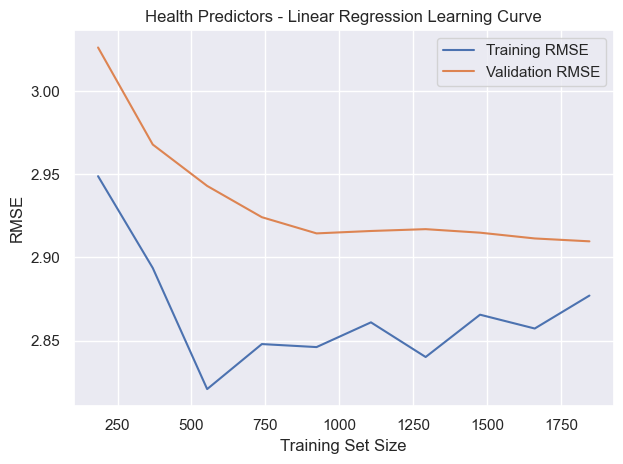

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error, 
                             median_absolute_error, explained_variance_score)
from sklearn.model_selection import cross_val_score, learning_curve, train_test_split
from sklearn.preprocessing import StandardScaler

# ===============================================================
# Modified evaluation function that returns a dictionary of metrics
# ===============================================================
def evaluate_model(model, full_name, X_train, y_train, X_test, y_test, plot=True):
    # Fit the model and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Compute various evaluation metrics
    mse    = mean_squared_error(y_test, y_pred)
    r2     = r2_score(y_test, y_pred)
    mae    = mean_absolute_error(y_test, y_pred)
    rmse   = np.sqrt(mse)
    medae  = median_absolute_error(y_test, y_pred)
    evs    = explained_variance_score(y_test, y_pred)
    n      = len(y_test)
    p      = X_test.shape[1]
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    # 5-fold cross-validation RMSE on the training set
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse   = np.sqrt(-cv_scores).mean()
    
    # Optionally plot a residual plot
    if plot:
        residuals = y_test - y_pred
        plt.figure()
        plt.scatter(y_pred, residuals, alpha=0.7)
        plt.axhline(0, color='black', linestyle='--')
        plt.xlabel("Predicted Values")
        plt.ylabel("Residuals")
        plt.title(f"Residual Plot - {full_name}")
        plt.show()
    
    # Print a summary for the model
    print(f"========== {full_name} ==========")
    print("Test MSE:", mse)
    print("Test R²:", r2)
    print("Test MAE:", mae)
    print("Test RMSE:", rmse)
    print("Test Median AE:", medae)
    print("Explained Variance:", evs)
    print("Adjusted R²:", adjusted_r2)
    print("Cross-validated RMSE:", cv_rmse)
    
    return {
       "Model": "",  # Will be overwritten in the pipeline function
       "Test MSE": mse,
       "Test R²": r2,
       "Test MAE": mae,
       "Test RMSE": rmse,
       "Test MedAE": medae,
       "Explained Variance": evs,
       "Adjusted R²": adjusted_r2,
       "CV RMSE": cv_rmse
    }

# ===============================================================
# Pipeline function for splitting, scaling, evaluating, and summarizing
# ===============================================================
def run_model_pipeline(X, Y, category_name, test_size=0.2, random_state=135):
    """
    Processes predictor set X for a given category:
      - Converts to floats, splits into train and test,
      - Scales data and adds a constant,
      - Fits multiple regression models,
      - Collects key evaluation metrics,
      - Plots summary bar charts for all metrics and then prints a table (in text) for the metric,
      - Plots a learning curve for Linear Regression.
      
    Parameters:
        X (DataFrame): Predictor features for the category.
        Y (Series): Target variable.
        category_name (str): e.g., "Environmental".
        test_size (float): Proportion for testing.
        random_state (int): Seed for reproducibility.
        
    Returns:
        summary_df (DataFrame): A summary table of evaluation metrics for each model.
    """
    # Convert data type to float
    X = X.astype(float)
    Y = Y.astype(float)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=test_size, random_state=random_state
    )
    
    # Scale the predictors
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    
    # Convert back to DataFrame to retain column names
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled  = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    
    # Add a constant for the intercept
    X_train_scaled = sm.add_constant(X_train_scaled)
    X_test_scaled  = sm.add_constant(X_test_scaled)
    
    print("================================")
    print(f"Category: {category_name}")
    print("================================")
    
    # Define regression models and their short names for summaries
    models = [
       (LinearRegression(),         "Linear Regression"),
       (Ridge(alpha=1.0),          "Ridge Regression"),
       (Lasso(alpha=0.1),          "Lasso Regression"),
       (ElasticNet(alpha=0.1, l1_ratio=0.5),  "ElasticNet Regression"),
       (DecisionTreeRegressor(random_state=42), "Decision Tree Regression"),
       (RandomForestRegressor(random_state=42), "Random Forest Regression")
    ]
    
    # Evaluate each model and collect metrics
    results_summary = []
    for model, short_name in models:
       full_name = f"{category_name} - {short_name}"
       metrics_dict = evaluate_model(
           model, full_name, X_train_scaled, y_train, X_test_scaled, y_test, plot=False
       )
       metrics_dict["Model"] = short_name  # Overwrite with short name only
       results_summary.append(metrics_dict)
       
    # Create a summary DataFrame
    summary_df = pd.DataFrame(results_summary)
    print("\nSummary of Evaluation Metrics:")
    print(summary_df)
    
    # List of metrics to plot and print a table below the figure
    metric_names = ["Test MSE", "Test R²", "Test MAE", "Test RMSE", "Test MedAE", "Explained Variance", "Adjusted R²", "CV RMSE"]
    
    # Loop over each metric to create a bar chart and then print a table
    for metric in metric_names:
        plt.bar(summary_df["Model"], summary_df[metric])
        plt.xticks(rotation=45, ha="right")
        plt.title(f"{category_name} Predictors - {metric} Comparison")
        plt.ylabel(metric)
        plt.tight_layout()
        plt.show()
        
        # Print the summary table for this metric
        print(f"\nSummary Table for {metric}:")
        print(summary_df[["Model", metric]].to_string(index=False))
        print("\n")
    
    # Additionally, plot a learning curve for Linear Regression only
    train_sizes, train_scores, valid_scores = learning_curve(
       estimator=LinearRegression(),
       X=X_train_scaled,
       y=y_train,
       train_sizes=np.linspace(0.1, 1.0, 10),
       cv=5,
       scoring='neg_mean_squared_error'
    )
    train_rmse = np.sqrt(-train_scores.mean(axis=1))
    valid_rmse = np.sqrt(-valid_scores.mean(axis=1))
    plt.plot(train_sizes, train_rmse, label='Training RMSE')
    plt.plot(train_sizes, valid_rmse, label='Validation RMSE')
    plt.xlabel('Training Set Size')
    plt.ylabel('RMSE')
    plt.title(f'{category_name} Predictors - Linear Regression Learning Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return summary_df

# ===============================================================
# Example Usage:
# (Make sure you have defined your reduced predictor sets and Y)
#
summary_env    = run_model_pipeline(X_env_reduced, Y, "Environmental")
summary_socio  = run_model_pipeline(X_socio_reduced, Y, "Socioeconomic")
summary_health = run_model_pipeline(X_health_reduced, Y, "Health")
